# Setup Development Environment

In [2]:
%pip install  --upgrade \
  "transformers==4.44.2" \
  "datasets==2.21.0" \
  "evaluate==0.4.2"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uni

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

# Load and prepare the dataset

In [28]:
def select_conversation(sample):
    return {
      "messages": sample["conversation_a"]
    }

In [26]:
from datasets import load_dataset

# Load dataset from the hub
seed = 42
dataset = load_dataset("lmsys/chatbot_arena_conversations", split="train")
dataset = dataset.shuffle(seed=seed).select(range(3000))
dataset[0]

{'question_id': '39fa4c50b8d54d3180d076a293e1dbef',
 'model_a': 'vicuna-13b',
 'model_b': 'RWKV-4-Raven-14B',
 'winner': 'model_b',
 'judge': 'arena_user_14268',
 'conversation_a': [{'content': 'Oauth 2.0 define the url to the token endpoint?',
   'role': 'user'},
  {'content': 'Yes, OAuth 2.0 defines a specific URL to the token endpoint. This URL is typically registered with the authorization server during the client registration process and is used by the client to request an access token.\n\nThe token endpoint URL is typically in the form of a URI (Uniform Resource Identifier) and is specified in the OAuth 2.0 protocol as the "token URL" or "access token URL". The exact URL will depend on the authorization server implementation and the specific OAuth 2.0 flow being used.\n\nFor example, in the Authorization Code Flow, the token endpoint URL is typically in the following format:\n```php\nhttps://your-authorization-server.com/token\n```\nIn this example, "your-authorization-server.com

In [29]:
dataset = dataset.map(select_conversation, batched=False)
dataset = dataset.remove_columns(['question_id',
  'model_a',
  'model_b',
  'winner',
  'judge',
  'conversation_a',
  'conversation_b',
  'turn',
  'anony',
  'language',
  'tstamp',
  'openai_moderation',
  'toxic_chat_tag']
)

dataset[0]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

{'messages': [{'content': 'Oauth 2.0 define the url to the token endpoint?',
   'role': 'user'},
  {'content': 'Yes, OAuth 2.0 defines a specific URL to the token endpoint. This URL is typically registered with the authorization server during the client registration process and is used by the client to request an access token.\n\nThe token endpoint URL is typically in the form of a URI (Uniform Resource Identifier) and is specified in the OAuth 2.0 protocol as the "token URL" or "access token URL". The exact URL will depend on the authorization server implementation and the specific OAuth 2.0 flow being used.\n\nFor example, in the Authorization Code Flow, the token endpoint URL is typically in the following format:\n```php\nhttps://your-authorization-server.com/token\n```\nIn this example, "your-authorization-server.com" is the domain name of the authorization server. The client can use this URL to request an access token by making a POST request to the URL, including the client\'s cr

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset

def calculate_token_lengths(sample, tokenizer):
    prompt_tokens = tokenizer(sample["messages"][0]["content"], truncation=False)['input_ids']
    completion_tokens = tokenizer(sample["messages"][1]["content"], truncation=False)['input_ids']
    return {
        'prompt_tokens': len(prompt_tokens),
        'completion_tokens': len(completion_tokens),
        'total_tokens': len(prompt_tokens) + len(completion_tokens)
    }


def display_token_distribution_and_percentiles(dataset, tokenizer):
    token_lengths = dataset.map(lambda x: calculate_token_lengths(x, tokenizer), batched=False)

    lengths_dict = {
        'Prompt (Input)': np.array(token_lengths['prompt_tokens']),
        'Completion (Output)': np.array(token_lengths['completion_tokens']),
        'Combined (Input + Output)': np.array(token_lengths['total_tokens'])
    }

    plt.figure(figsize=(10, 8))
    for i, (label, lengths) in enumerate(lengths_dict.items(), 1):
        plt.subplot(len(lengths_dict.items()), 1, i)
        plt.hist(lengths, bins=50, alpha=0.7, label=label)
        plt.title(f'Token Length Distribution for {label}')
        plt.xlabel('Token Length')
        plt.ylabel('Frequency')
        plt.legend()

    plt.tight_layout()
    plt.show()

    def print_summary_statistics(data, label):
        print(f"\n{label} Token Length Summary:")
        df = pd.Series(data)
        print(df.describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]))

    for label, lengths in lengths_dict.items():
        print_summary_statistics(lengths, label)

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

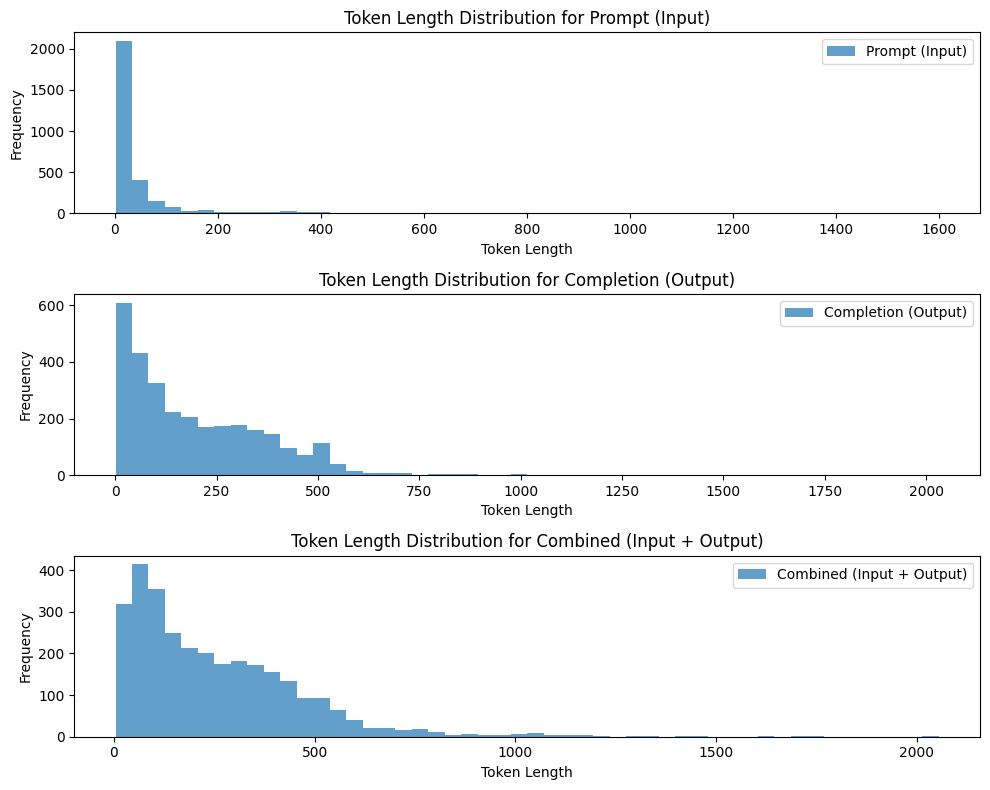


Prompt (Input) Token Length Summary:
count    3000.000000
mean       56.101667
std       112.091939
min         2.000000
50%        20.000000
75%        41.000000
90%       121.000000
95%       283.150000
99%       612.040000
max      1599.000000
dtype: float64

Completion (Output) Token Length Summary:
count    3000.000000
mean      196.632333
std       177.119000
min         1.000000
50%       143.000000
75%       308.000000
90%       438.100000
95%       513.000000
99%       687.020000
max      2031.000000
dtype: float64

Combined (Input + Output) Token Length Summary:
count    3000.00000
mean      252.73400
std       216.47454
min         4.00000
50%       198.00000
75%       367.00000
90%       520.00000
95%       612.15000
99%      1033.02000
max      2055.00000
dtype: float64


In [31]:
from transformers import AutoTokenizer

model_id = "lmsys/vicuna-7b-v1.5"
tokenizer = AutoTokenizer.from_pretrained(model_id)
display_token_distribution_and_percentiles(dataset, tokenizer)

In [32]:
train_test_split = dataset.train_test_split(test_size=0.3, seed=seed)
val_test_split = train_test_split['test'].train_test_split(test_size=0.5, seed=seed)

dataset = {
    'train': train_test_split['train'],
    'val': val_test_split['train'],
    'test': val_test_split['test']
}

# Check the number of examples in each split
print(f"Training set size: {len(dataset['train'])}")
print(f"Validation set size: {len(dataset['val'])}")
print(f"Test set size: {len(dataset['test'])}")

Training set size: 2100
Validation set size: 450
Test set size: 450


In [33]:
# save train_dataset to s3 using our SageMaker session
data_input_path = f'./datasets/chatbot_arena_conversations'

train_dataset_path = f"{data_input_path}/train/train_dataset.json"
eval_dataset_path = f"{data_input_path}/eval/eval_dataset.json"
test_dataset_path = f"{data_input_path}/test/test_dataset.json"

dataset["train"].to_json(train_dataset_path, orient="records")
dataset["val"].to_json(eval_dataset_path, orient="records")
dataset["test"].to_json(test_dataset_path, orient="records")

print(f"Training data uploaded to: {data_input_path}")

Creating json from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Training data uploaded to: ./datasets/chatbot_arena_conversations
